<a href="https://colab.research.google.com/github/illhyhl1111/SNU_ML2021/blob/main/Lab4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import gym
from pylab import plot
%matplotlib inline

아래는 agent가 놓이게 될 RL 환경 FrozenLake을 설명한다.
- 4$\times$4 gridworld 환경이며, agent가 취할 수 있는 action은 \{위, 아래, 오른쪽, 왼쪽\}으로 이동하는 것이다.
- episode의 시작에는 좌측 상단 코너에 agent가 위치되고 (`S`), 목적은 `H` 칸을 피하면서 `F`칸을 따라서 `G`칸까지 도달하는 것이다. (이 경우 +1 reward를 얻고, 나머지 경우에는 0 reward를 얻는다)
```
SFFF
FHFH
FFFH
HFFG
```
- 다만 (설정상) 길이 미끄러우므로 '오른쪽' action을 취해도 반드시 오른쪽으로 한 칸 간다는 보장이 없으며, 일정 확률로 그냥 제자리에 있거나 아래 칸으로 빠질 수도 있다. 즉, stochastic인 환경이다.
- observation/state은 agent의 현재 위치를 0, ..., 15 중 하나의 값으로 주어지고, action은 0, 1, 2, 3 중 하나의 값으로 취할 수 있다.

많은 RL 환경들은 `gym` 라이브러리에서 지정된 방식을 이용하는데, 이 `gym`으로 구현된 환경들은 `reset` 함수와 `step` 함수를 지니고 있다. \\
`reset()`은 환경의 episode를 새로 시작하며, 현재 state를 return한다.
`step(action)`은 현재 상태에서 action을 취하여 `(next_state, reward, done, info)` tuple을 return한다.

In [ ]:
env=gym.make('FrozenLake-v0')

print(env.reset())

print(env.observation_space)
print(env.action_space)

print(env.step(0))  # Perform one arbitrary action
# next state, reward, done (whether episode finished or not), and info (environment-related meta-info) are returned

0
Discrete(16)
Discrete(4)
(0, 0.0, False, {'prob': 0.3333333333333333})


아래는 이후에 학습 과정에서 이용할 hyperparameter 들이다.

In [ ]:
num_episodes = 5000       # Number of episodes to train for
episode_max_length = 100  # Max length of one episode
gamma = 0.95              # Discount factor
lr = 0.8                  # Learning rate
c = 2e-5                  # Coefficient for upper confidence bound (UCB)

아래는 reward를 smoothing하여 기록하기 위한 (moving average를 계산하는) helper function이다.


In [ ]:
def moving_average(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')


action을 고르는 방식은 다양한데, 이 예시에서는 수업에서 배운 $\varepsilon$-greedy가 아니라 Upper Confidence Bound (UCB) 방식을 쓴다.
UCB는 아래와 같이 action을 고른다.
$$
A_t = \text{argmax}_a \left[ Q_t(S_t,a) + c \sqrt{ \frac{\log t}{N_t (S_t, a)}} \right]
$$

- $c$는 hyperparameter
- $t$는 현재 시간 (episode 내의 시간이 아니라 이전 episode들 포함한 모든 time steps)
- $N_t(s, a)$는 현재 $t$ 시점까지 $(s,a)$를 마주친 횟수이다.


In [ ]:
# Action selection via UCB
def ucb_action_selection(episode, state):
    global Q, env, visit_counts, c
    # argmax_a (Q_t + c*sqrt(log(episode num)/N_t))
    return np.argmax(Q[state] + c * np.sqrt(np.log(episode + 1.0) / visit_counts[state]))

아래는 SARSA training code이다.

SARSA는 아래와 같은 방식으로 업데이트 한다.
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t))
$$


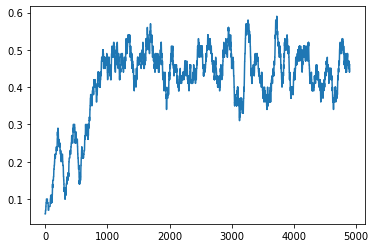

In [ ]:
# Initialize variables
rwd_list = []
Q=np.zeros([env.observation_space.n,env.action_space.n]) # Q function

# Visit counts (N_t in the UCB formula)
# Small value was added to avoid division by zero
visit_counts = np.zeros_like(Q) + 1e-5

# Run episodes
for ep_idx in range(num_episodes):
    # Reset the environment at the beginning of an episode
    state = env.reset()
    action = ucb_action_selection(ep_idx, state)  # This can be epsilon-greedy if needed
    done = False

    episode_rwd = 0.0
   
    # Run a single episode
    for t in range(episode_max_length):
        
        # Execute an action, get next state and reward
        next_state, rwd, done, _ = env.step(action)

        episode_rwd += rwd
        
        # Visited state-action pair
        visit_counts[state, action] += 1
        
        # Get next action
        next_action = ucb_action_selection(ep_idx, next_state)

        # Update Q function
        Q[state, action] += lr * (rwd + gamma * Q[next_state, next_action] - Q[state, action])
        
        if done == True:
            break
        state = next_state
        action = next_action
    
    rwd_list.append(episode_rwd)

# Plot the rewards
plot(moving_average(rwd_list, 100))

아래는 Q-learning code이다.

Q-learning은 아래와 같은 방식으로 업데이트 한다.
$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha (R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t))
$$



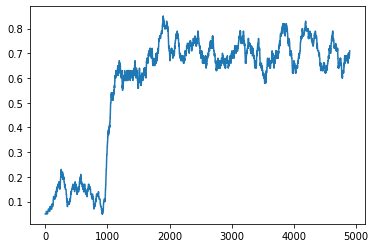

In [ ]:
# Initialize variables
rwd_list = []
Q=np.zeros([env.observation_space.n,env.action_space.n]) # Q function

# Visit counts (N_t in the UCB formula)
# Small value was added to avoid division by zero
visit_counts = np.zeros_like(Q) + 1e-5

# Run episodes
for ep_idx in range(num_episodes):
    # Reset the environment at the beginning of an episode
    state = env.reset()
    done = False

    episode_rwd = 0.0
   
    # Run a single episode
    for t in range(episode_max_length):
        action = ucb_action_selection(ep_idx, state)  # This can be epsilon-greedy if needed

        # Execute an action, get next state and reward
        next_state, rwd, done, _ = env.step(action)

        episode_rwd += rwd
        
        # Visited state-action pair
        visit_counts[state, action] += 1
        
        # Get next action
        next_action = ucb_action_selection(ep_idx, next_state)

        # Update Q function (This is the only part that mainly changed)
        Q[state, action] += lr * (rwd + gamma * np.max(Q[next_state]) - Q[state, action])
        
        if done == True:
            break
        state = next_state
        action = next_action
    
    rwd_list.append(episode_rwd)

# Plot the rewards
plot(moving_average(rwd_list, 100))